In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
data = pd.read_csv('../data/hmeq_clean.csv')
data.drop(columns=['Unnamed: 0'],inplace=True)

In [34]:
data_cat = pd.read_csv('../data/data_0.csv')
data_cat.drop(columns=['Unnamed: 0'],inplace=True)

In [35]:
data_del_null = pd.read_csv('../data/hmeq_clean_del_null.csv')
data_del_null.drop(columns=['Unnamed: 0'],inplace=True)

In [36]:
data_del_debtinc = pd.read_csv('../data/hmeq_clean_del_debtinc.csv')
data_del_debtinc.drop(columns=['Unnamed: 0'],inplace=True)

In [37]:
data_del_null_cat = pd.read_csv('../data/data_1.csv')
data_del_null_cat.drop(columns=['Unnamed: 0'],inplace=True)

In [38]:
data_del_debtinc_cat = pd.read_csv('../data/data_2.csv')
data_del_debtinc_cat.drop(columns=['Unnamed: 0'],inplace=True)

In [39]:
data_norm_cat = pd.read_csv('../data/hmeq_normalised_cat.csv')
data_norm_cat.drop(columns=['Unnamed: 0'],inplace=True)

In [40]:
data_norm = pd.read_csv('../data/hmeq_normalised.csv')
data_norm.drop(columns=['Unnamed: 0'],inplace=True)

In [138]:
dfs = [data,data_cat,data_del_null,data_del_debtinc,data_del_null_cat,data_del_debtinc_cat]

In [139]:
y = data['BAD']

If there are any highly correlated columns I would like to delete the feature, but there are not any

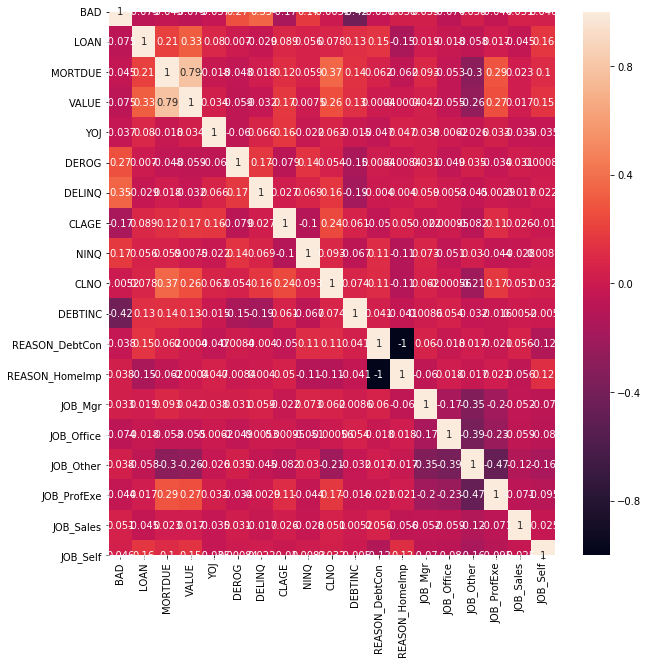

In [140]:
correlation_matrix = data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True);

In [141]:
data.isnull().sum()

BAD               0
LOAN              0
MORTDUE           0
VALUE             0
YOJ               0
DEROG             0
DELINQ            0
CLAGE             0
NINQ              0
CLNO              0
DEBTINC           0
REASON_DebtCon    0
REASON_HomeImp    0
JOB_Mgr           0
JOB_Office        0
JOB_Other         0
JOB_ProfExe       0
JOB_Sales         0
JOB_Self          0
dtype: int64

In [142]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline

pipeline = [
    StandardScaler(),
    Normalizer(),
]

def pipelinise(df):
    X = df.drop(columns=['BAD']) #FEATURE VECTOR
    tr = make_pipeline(*pipeline)
    Xpr = tr.fit_transform(X)
    dataf = pd.DataFrame(Xpr,columns=X.columns)
    dataf['BAD'] = df['BAD']
    return dataf

[dfs.append(pipelinise(dfs[i])) for i in range(6)]


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/luciasuelves/opt/anaconda3/lib/python

[None, None, None, None, None, None]

In [144]:
from sklearn.model_selection import train_test_split
"""
def split(df):
    Xpr = pipelinise(df)
    return train_test_split(Xpr,y , test_size=0.2,random_state=10)
"""
def split(df):
    return train_test_split(df.drop(columns=['BAD']),df['BAD'] , test_size=0.2,random_state=10)

In [145]:
from sklearn.linear_model import LogisticRegression

def log_reg(df):
    X_train,X_test,y_train,y_test = split(df)
    print(X_train.shape)
    model = LogisticRegression(solver="lbfgs")
    model.fit(X_train, y_train)
    return (model,X_test,y_test)

In [146]:
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def scoring(df):
    y_personalised = []
    neg = 0
    pos = 0
    model,X_test,y_test = log_reg(df)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
     
    for i in range(len(y_score)):
        if y_score[:,1][i] > 0.4:
            y_personalised.append(1)
        else:
            y_personalised.append(0)
            
    roc = roc_curve(y_test, y_personalised)        
    #roc = roc_curve(y_test, y_score[:,1])
    #display(pd.DataFrame({
    #    "predicted":y_pred,
    #    "personalised": y_personalised,
    #    "gt": y_test,
    #    "probaNotPay":y_score[:,1],
    #    "probaPay":y_score[:,0]
    #    }).head())
    plt.figure()
    plt.plot(roc[0],roc[1])
    plt.legend([f"AUC: {round(roc_auc_score(y_test, y_score[:,1]),2)}"])
    #model.predict_proba(X_test)[0]
    result = pd.DataFrame({
    "y_pred":y_pred,
    "gt":y_test
                })


    for i in range(len(y_pred)):
        if y_personalised[i] < y_test.values[i]:
            neg += 1
        elif y_personalised[i] > y_test.values[i]:
            pos += 1
            
    return (1-np.abs(y_personalised-y_test).sum()/len(y_test),1-np.abs(y_pred-y_test).sum()/len(y_test), neg/(pos+neg))

(4768, 18)
(4768, 12)


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(4128, 18)
(4128, 18)
(4128, 12)


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


(4128, 12)
(4768, 18)
(4768, 12)
(4128, 18)
(4128, 18)
(4128, 12)
(4128, 12)


[(0.8515100671140939, 0.8338926174496644, 0.536723163841808),
 (0.8523489932885906, 0.8439597315436241, 0.5625),
 (0.8488372093023255, 0.8362403100775193, 0.5769230769230769),
 (0.8488372093023255, 0.8362403100775193, 0.5769230769230769),
 (0.8488372093023255, 0.8391472868217054, 0.5769230769230769),
 (0.8488372093023255, 0.8391472868217054, 0.5769230769230769),
 (0.8439597315436241, 0.8515100671140939, 0.5752688172043011),
 (0.8406040268456376, 0.8447986577181208, 0.5473684210526316),
 (0.8468992248062015, 0.8594961240310077, 0.5506329113924051),
 (0.8468992248062015, 0.8594961240310077, 0.5506329113924051),
 (0.8488372093023255, 0.8624031007751938, 0.5512820512820513),
 (0.8488372093023255, 0.8624031007751938, 0.5512820512820513)]

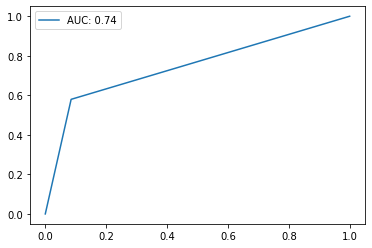

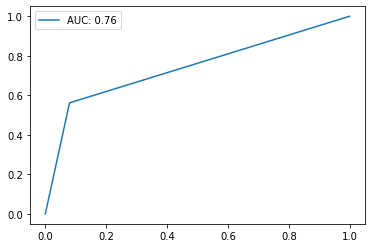

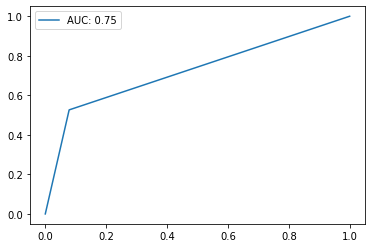

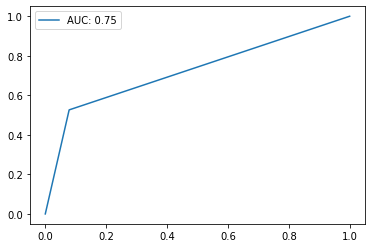

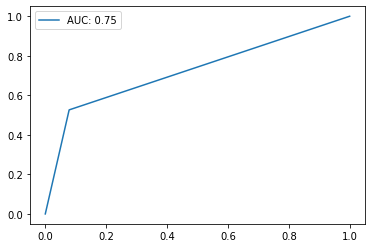

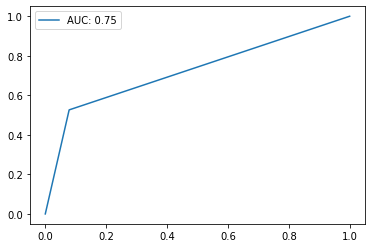

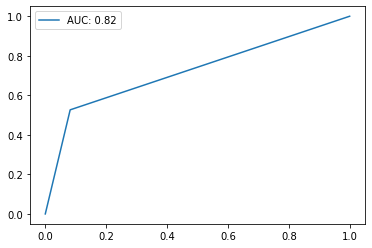

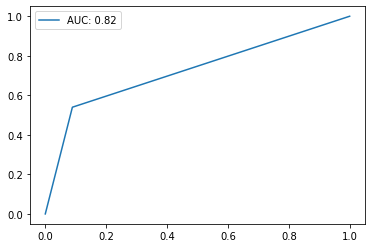

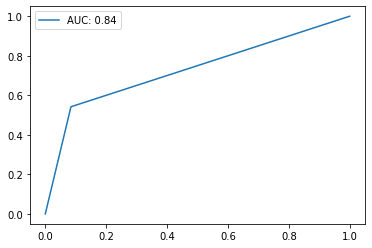

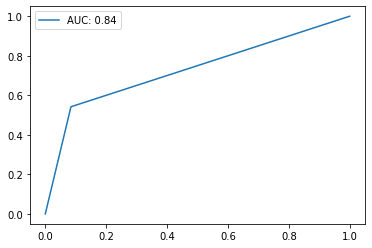

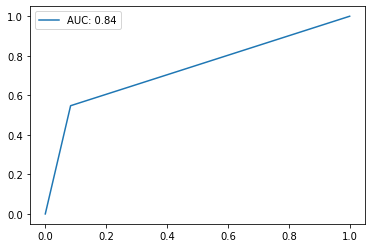

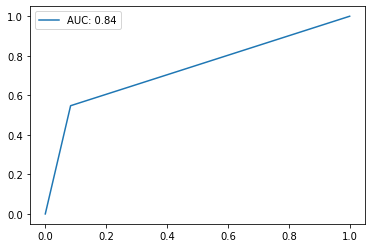

In [147]:
[scoring(df) for df in dfs]
# Hay mas errores de dar un loan a alguien que luego no paga. 
# Podemos hacer que la probabilidad que necesita a su favor sea más alta.

In the causalnex model, I need to select a limited number of features, so to choose them I could use the following

In [148]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

X = data.drop(columns=['BAD'])
featurer = SelectKBest(chi2, k=5)
X_new = featurer.fit_transform(np.abs(X), y)

In [149]:
print(X.columns[featurer.get_support()])

Index(['LOAN', 'MORTDUE', 'VALUE', 'CLAGE', 'DEBTINC'], dtype='object')


(4768, 5)


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0.8506711409395973, 0.8288590604026845, 0.5393258426966292)

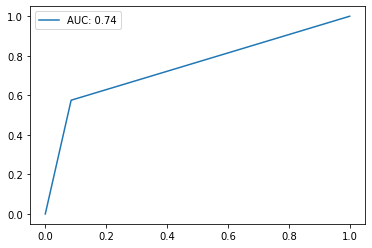

In [150]:
data_reduced = X[X.columns[featurer.get_support()]]
data_reduced['BAD'] = y
dfs.append(data_reduced)
scoring(data_reduced)

Its worse

What's worse? To give the loan and not pay or to not give the loan and pay? I have to change the percentages.

In [ ]:
#I don't know

In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train(df):
    X_train,X_test,y_train,y_test = split(df)
    models = {
        "logis": LogisticRegression(C=10,solver="lbfgs"),
        "svm-linear": CalibratedClassifierCV(LinearSVC(),cv=3),
        "svm-rbf": CalibratedClassifierCV(SVC(kernel="sigmoid",gamma="auto"),cv=3),
        "randomforest": RandomForestClassifier(n_estimators=200),
    }

# Train all the models in the models dict
    for name,m  in models.items():
        print(f"Training {name}...")
        m.fit(X_train, y_train)
    print("Train complete")
    

    printMetric = lambda label,value:print(f"\t {label}: {round(value,3)}")

    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(f"Evaluating model {name}")
        printMetric("Accuracy",accuracy_score(y_test, y_pred))
        printMetric("Precision",precision_score(y_test, y_pred))
        printMetric("Recall",recall_score(y_test, y_pred))
        printMetric("F1Score",f1_score(y_test, y_pred))

    return("Train complete")

In [152]:
[train(df) for df in dfs]

Training logis...
Training svm-linear...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.834
	 Precision: 0.694
	 Recall: 0.221
	 F1Score: 0.336
Evaluating model svm-linear
	 Accuracy: 0.81
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.81
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.905
	 Precision: 0.83
	 Recall: 0.628
	 F1Score: 0.715
Training logis...
Training svm-linear...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lucia

Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.832
	 Precision: 0.676
	 Recall: 0.221
	 F1Score: 0.333
Evaluating model svm-linear
	 Accuracy: 0.81
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.81
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.911
	 Precision: 0.837
	 Recall: 0.659
	 F1Score: 0.738
Training logis...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training svm-linear...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.836
	 Precision: 0.608
	 Recall: 0.311
	 F1Score: 0.411
Evaluating model svm-linear
	 Accuracy: 0.816
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.816
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.912
	 Precision: 0.8
	 Recall: 0.695
	 F1Score: 0.744
Training logis...
Training svm-linear...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lucia

Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.836
	 Precision: 0.608
	 Recall: 0.311
	 F1Score: 0.411
Evaluating model svm-linear
	 Accuracy: 0.816
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.816
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.913
	 Precision: 0.798
	 Recall: 0.705
	 F1Score: 0.749
Training logis...
Training svm-linear...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lucia

Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.838
	 Precision: 0.616
	 Recall: 0.321
	 F1Score: 0.422
Evaluating model svm-linear
	 Accuracy: 0.816
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.816
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.908
	 Precision: 0.791
	 Recall: 0.679
	 F1Score: 0.731
Training logis...
Training svm-linear...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lucia

Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.838
	 Precision: 0.616
	 Recall: 0.321
	 F1Score: 0.422
Evaluating model svm-linear
	 Accuracy: 0.816
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.816
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.911
	 Precision: 0.788
	 Recall: 0.705
	 F1Score: 0.744
Training logis...
Training svm-linear...
Training svm-rbf...


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.851
	 Precision: 0.669
	 Recall: 0.42
	 F1Score: 0.516
Evaluating model svm-linear
	 Accuracy: 0.845
	 Precision: 0.643
	 Recall: 0.407
	 F1Score: 0.499
Evaluating model svm-rbf
	 Accuracy: 0.841
	 Precision: 0.636
	 Recall: 0.372
	 F1Score: 0.469
Evaluating model randomforest
	 Accuracy: 0.896
	 Precision: 0.797
	 Recall: 0.606
	 F1Score: 0.688
Training logis...
Training svm-linear...
Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.846
	 Precision: 0.646
	 Recall: 0.412
	 F1Score: 0.503
Evaluating model svm-linear
	 Accuracy: 0.839
	 Precision: 0.621
	 Recall: 0.385
	 F1Score: 0.475
Evaluating model svm-rbf
	 Accuracy: 0.839
	 Precision: 0.621
	 Recall: 0.385
	 F1Score: 0.475
Evaluating model randomforest
	 Accuracy: 0.9
	 Precision: 0.828
	 Recall: 0.597
	 F1Score: 0.694
Training logis...
Training svm-linear...
Training svm-rbf...
Training randomforest...
Trai

/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training svm-rbf...
Training randomforest...
Train complete
Evaluating model logis
	 Accuracy: 0.829
	 Precision: 0.683
	 Recall: 0.181
	 F1Score: 0.287
Evaluating model svm-linear
	 Accuracy: 0.81
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model svm-rbf
	 Accuracy: 0.81
	 Precision: 0.0
	 Recall: 0.0
	 F1Score: 0.0
Evaluating model randomforest
	 Accuracy: 0.878
	 Precision: 0.717
	 Recall: 0.584
	 F1Score: 0.644


/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luciasuelves/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


['Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete',
 'Train complete']